# Importing Libraries

In [1]:
from pyspark.sql.types import StructType, StructField, FloatType, LongType, StringType
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# Creating a Dataframe

Let's load our Yelp json files for businesses,checkins, and reviews into separate<br> spark 'dataframe' - Spark's abstraction for working with tabular data (built on top of RDDs)

In [4]:
df_business = sqlContext.read.json("dataset/business.json")
df_checkin = sqlContext.read.json("dataset/checkin.json")
df_review = sqlContext.read.json("dataset/review.json")
df_user = sqlContext.read.json("dataset/user.json")

In [5]:
df_business.describe()

DataFrame[summary: string, address: string, business_id: string, city: string, is_open: string, latitude: string, longitude: string, name: string, neighborhood: string, postal_code: string, review_count: string, stars: string, state: string]

In [6]:
df_checkin.describe()

DataFrame[summary: string, business_id: string]

In [7]:
df_review.describe()

DataFrame[summary: string, business_id: string, cool: string, date: string, funny: string, review_id: string, stars: string, text: string, useful: string, user_id: string]

In [8]:
df_user.describe()

DataFrame[summary: string, average_stars: string, compliment_cool: string, compliment_cute: string, compliment_funny: string, compliment_hot: string, compliment_list: string, compliment_more: string, compliment_note: string, compliment_photos: string, compliment_plain: string, compliment_profile: string, compliment_writer: string, cool: string, fans: string, funny: string, name: string, review_count: string, useful: string, user_id: string, yelping_since: string]

<h2> Question:</h2>
<h3>How does an influential user affect the Reviews for a business?</h3>

We want to find out if reviews left by influential users(defined here as having more than a certain number of followers) affects the checkin rates at a particular business.<br>
For starting off we will pick this approach:<br>
1) Pick an influential user<br>
2) Look at businesses where he/she left a review<br>
3) Find the nature of the reveiw, whether postive or negative<br>
4) Find a trend for the reviews for the business before and after the 'influencer' posted their review

<h3>Picking an influential user</h3><br>
We utilize the user dataframe and look for records where the user has a sisgnificant number of fans(top 3)

In [9]:
# from pyspark.sql.types import IntegerType
# df2_user = df_user.withColumn("fans_int", df_user['fans'].cast(IntegerType()))
# df2_user.drop("fans")
# df2_user.withColumnRenamed("fans_int", "fans")

In [10]:
df_user.select('user_id','fans').filter(df_user['fans']>2000).show()

+--------------------+----+
|             user_id|fans|
+--------------------+----+
|hizGc5W1tBHPghM5Y...|2344|
|iLjMdZi0Tm7DQxX1C...|2052|
|37cpUoM8hlkSQfReI...|6087|
+--------------------+----+



We choose the influencer with the higherst number of fans

In [11]:
# df2_user.select('user_id','fans').filter(df_user.select('fans')==max(df2_user.select('fans'))).show()

In [13]:
df_user.agg({"fans": "max"}).collect()

[Row(max(fans)=6087)]

Lets get the corresponding user_id

In [16]:
df_influencer = df_user.select('user_id','fans').filter(df_user['fans']==6087).collect()

In [ ]:
type(df_influencer)

In [ ]:
df_influencer[0]

Now, our Influencer has user_id: <b>37cpUoM8hlkSQfReIEBd-Q</b> who has 6087 fans

<h3>Look at businesses where Influential user left a review</h3>

In [65]:
df_business = df_review.select('business_id','stars','user_id','date').filter(df_review['user_id']=='37cpUoM8hlkSQfReIEBd-Q').collect()

We choose the first place in the list where the influencer left their review

In [66]:
df_business[0]

Row(business_id='0qet57CmMA5qUm6gPFUTpg', stars=2, user_id='37cpUoM8hlkSQfReIEBd-Q', date='2014-12-30')

The business where the influencer left their review has ID: <b>0qet57CmMA5qUm6gPFUTpg</b><br>
and they left a less than positive review of just <b>2 stars</b>
the review was left on <b>2014-12-30</b>

<h3>Analyzing Review trend</h3>

For the business we have identified, we would like to check the review trend before and after the Influencer left their review

In [67]:
df_review.describe()

DataFrame[summary: string, business_id: string, cool: string, date: string, funny: string, review_id: string, stars: string, text: string, useful: string, user_id: string]

In [68]:
df_review_trend_pre = df_review.select('stars','date').filter(df_review['business_id']=='0qet57CmMA5qUm6gPFUTpg').filter(df_review['date']<'2014-12-30')

In [69]:
df_review_trend_pre.show()

+-----+----------+
|stars|      date|
+-----+----------+
|    2|2014-12-28|
+-----+----------+



In [70]:
df_review_trend_post = df_review.select('stars','date').filter(df_review['business_id']=='0qet57CmMA5qUm6gPFUTpg').filter(df_review['date']>'2014-12-30')

In [71]:
df_review_trend_post.show()

+-----+----------+
|stars|      date|
+-----+----------+
|    5|2015-06-21|
|    1|2016-11-26|
|    4|2016-07-27|
|    3|2016-12-20|
|    4|2015-09-01|
|    3|2016-07-04|
|    2|2015-03-21|
|    2|2015-09-30|
|    2|2015-03-09|
|    2|2015-02-10|
|    1|2015-02-28|
|    5|2015-01-09|
|    3|2016-06-16|
|    4|2015-09-17|
|    2|2015-07-10|
|    1|2017-06-19|
|    2|2016-10-12|
|    1|2017-03-16|
|    2|2016-06-20|
|    1|2016-09-11|
+-----+----------+
only showing top 20 rows



In [72]:
df_review_trend_pre.agg({"stars": "avg"}).collect()

[Row(avg(stars)=2.0)]

In [73]:
df_review_trend_post.agg({"stars": "avg"}).collect()

[Row(avg(stars)=2.595505617977528)]

<h3>Observation:</h3><h4>We observe that there is a slight increase in the ratings, but the values is slightly unfair considering the fact that there was only 1 review prior to the influencer leaving their review</h4>

We repeat the analysis with another hotel that the influencer reviewed at

In [74]:
df_business[1]

Row(business_id='lYCeqldIiOggsbByH3RRhw', stars=3, user_id='37cpUoM8hlkSQfReIEBd-Q', date='2015-01-13')

In [75]:
df_review_trend_pre = df_review.select('stars','date').filter(df_review['business_id']=='lYCeqldIiOggsbByH3RRhw').filter(df_review['date']<'2015-01-13')

In [61]:
df_review_trend_pre.show()

+-----+----+
|stars|date|
+-----+----+
+-----+----+



<b>The empty set for prior reviews doesn't help us either</b>

In [62]:
df_review_trend_post = df_review.select('stars','date').filter(df_review['business_id']=='lYCeqldIiOggsbByH3RRhw').filter(df_review['date']>'2015-01-13')

In [63]:
df_review_trend_post.show()

+-----+----------+
|stars|      date|
+-----+----------+
|    1|2016-05-31|
|    1|2016-07-20|
|    2|2016-07-17|
|    1|2016-01-29|
|    5|2015-07-11|
|    2|2016-01-30|
|    4|2017-02-27|
|    4|2017-06-10|
|    3|2016-09-05|
|    2|2015-06-21|
|    4|2017-06-30|
+-----+----------+



<h3>In order to ensure a significant number of prior reviews we choose another Infleuncer, who has a significnt following as well. We do this in the following analysis</h3>

In [77]:
df_influencer = df_user.select('user_id','fans').filter(df_user['fans']==2344).collect()

In [78]:
df_influencer[0]

Row(user_id='hizGc5W1tBHPghM5YKCAtg', fans=2344)

In [79]:
df_business = df_review.select('business_id','stars','user_id','date').filter(df_review['user_id']=='hizGc5W1tBHPghM5YKCAtg').collect()

In [80]:
df_business[0]

Row(business_id='X8c23dur0ll2D9XTu-I8Qg', stars=1, user_id='hizGc5W1tBHPghM5YKCAtg', date='2013-08-29')

The business where the influencer left their review has ID: <b>X8c23dur0ll2D9XTu-I8Qg</b><br>
and they left a less than positive review of just <b>1 stars</b>
the review was left on <b>2013-08-29</b>

In [81]:
df_review_trend_pre = df_review.select('stars','date').filter(df_review['business_id']=='X8c23dur0ll2D9XTu-I8Qg').filter(df_review['date']<'2013-08-29')

In [22]:
df_review_trend_pre.show()

+-----+----------+
|stars|      date|
+-----+----------+
|    4|2013-08-05|
|    4|2013-08-09|
|    2|2013-08-19|
|    4|2013-07-12|
|    1|2013-07-30|
|    4|2013-05-22|
|    5|2013-06-26|
|    3|2013-07-27|
|    4|2013-06-20|
|    2|2013-08-10|
|    3|2013-08-26|
|    2|2013-04-29|
|    4|2013-08-16|
|    1|2013-04-20|
|    3|2013-06-03|
|    5|2013-05-26|
|    3|2013-05-02|
|    4|2013-05-30|
|    5|2013-07-31|
|    5|2013-07-30|
+-----+----------+
only showing top 20 rows



In [24]:
df_review_trend_post = df_review.select('stars','date').filter(df_review['business_id']=='X8c23dur0ll2D9XTu-I8Qg').filter(df_review['date']>'2013-08-29')

In [26]:
df_review_trend_post.show()

+-----+----------+
|stars|      date|
+-----+----------+
|    2|2017-06-16|
|    1|2016-06-24|
|    4|2014-05-28|
|    1|2016-06-27|
|    3|2015-07-01|
|    1|2014-10-07|
|    5|2013-09-17|
|    3|2013-09-14|
|    3|2013-10-10|
|    1|2015-01-11|
|    1|2017-06-29|
|    2|2016-10-12|
|    2|2015-01-15|
|    4|2014-03-01|
|    1|2016-01-14|
|    1|2017-04-08|
|    5|2016-08-16|
|    3|2014-09-13|
|    1|2014-04-22|
|    1|2016-05-14|
+-----+----------+
only showing top 20 rows



In [30]:
df_review_trend_pre.agg({"stars": "avg"}).collect()

[Row(avg(stars)=2.8444444444444446)]

In [28]:
df_review_trend_post.agg({"stars": "avg"}).collect()

[Row(avg(stars)=2.5)]

We observe that the average rating of the Business dropped after the influential users negative review of just 1 start. Needless to say, there are definitely other factors which affect the ratings, nut we believe user review must play a significant role.

<h4> Repeating analysis for other business where the user left a review</h4>

<h2>1</h2>

In [34]:
df_business[2]

Row(business_id='dzmBn58boDASCg_LeAgNiA', stars=4, user_id='hizGc5W1tBHPghM5YKCAtg', date='2010-03-22')

In [35]:
df_review_trend_pre = df_review.select('stars','date').filter(df_review['business_id']=='dzmBn58boDASCg_LeAgNiA').filter(df_review['date']<'2010-03-22')

In [36]:
df_review_trend_pre.show()

+-----+----------+
|stars|      date|
+-----+----------+
|    3|2009-03-02|
|    3|2007-08-14|
|    3|2007-12-19|
|    3|2009-12-16|
|    4|2007-01-23|
|    4|2008-04-07|
|    4|2008-05-22|
|    1|2009-04-04|
|    4|2007-05-08|
|    3|2008-09-30|
|    4|2008-08-02|
|    1|2009-11-19|
|    4|2006-12-12|
|    2|2007-01-31|
|    1|2009-09-26|
|    2|2009-08-12|
|    4|2007-09-14|
|    2|2009-10-04|
|    3|2007-07-26|
|    1|2009-08-23|
+-----+----------+
only showing top 20 rows



In [37]:
df_review_trend_post = df_review.select('stars','date').filter(df_review['business_id']=='dzmBn58boDASCg_LeAgNiA').filter(df_review['date']>'2010-03-22')

In [38]:
df_review_trend_post.show()

+-----+----------+
|stars|      date|
+-----+----------+
|    4|2011-03-27|
|    1|2012-01-19|
|    3|2010-08-18|
|    3|2012-01-19|
|    1|2010-08-30|
|    3|2010-09-11|
|    3|2010-06-12|
|    1|2012-04-25|
+-----+----------+



In [39]:
df_review_trend_pre.agg({"stars": "avg"}).collect()

[Row(avg(stars)=2.8095238095238093)]

In [40]:
df_review_trend_post.agg({"stars": "avg"}).collect()

[Row(avg(stars)=2.375)]

<h2>2</h2>

In [41]:
df_business[3]

Row(business_id='TYQTocZ1bHcZh6WR5k8vBA', stars=4, user_id='hizGc5W1tBHPghM5YKCAtg', date='2015-08-28')

In [45]:
df_review_trend_pre = df_review.select('stars','date').filter(df_review['business_id']=='TYQTocZ1bHcZh6WR5k8vBA').filter(df_review['date']<'2015-08-28')

In [46]:
df_review_trend_post = df_review.select('stars','date').filter(df_review['business_id']=='TYQTocZ1bHcZh6WR5k8vBA').filter(df_review['date']>'2015-08-28')

In [47]:
df_review_trend_pre.agg({"stars": "avg"}).collect()

[Row(avg(stars)=4.5)]

In [48]:
df_review_trend_post.agg({"stars": "avg"}).collect()

[Row(avg(stars)=3.125)]

<h2>3</h2>

In [49]:
df_business[4]

Row(business_id='e8gYjgoYBwPSZMwNYg-hnA', stars=5, user_id='hizGc5W1tBHPghM5YKCAtg', date='2009-11-20')

In [50]:
df_review_trend_pre = df_review.select('stars','date').filter(df_review['business_id']=='e8gYjgoYBwPSZMwNYg-hnA').filter(df_review['date']<'2009-11-20')

In [51]:
df_review_trend_post = df_review.select('stars','date').filter(df_review['business_id']=='e8gYjgoYBwPSZMwNYg-hnA').filter(df_review['date']>'2009-11-20')

In [52]:
df_review_trend_pre.agg({"stars": "avg"}).collect()

[Row(avg(stars)=4.0)]

In [53]:
df_review_trend_post.agg({"stars": "avg"}).collect()

[Row(avg(stars)=4.5)]

<h2>Visualization</h2>

Creating a pandas dataframe from the values that we observed in the above cells

In [95]:
trend = {'stars': [2.8, 2.5,2.8,2.3,4.5,3.1,4,4.5], 'time': ['before', 'after','before','after','before','after','before','after'],'review':[1,1,4,4,4,4,5,5]}

In [96]:
trend = pd.DataFrame(data=trend)

In [97]:
trend.head(8)

review  stars    time
0       1    2.8  before
1       1    2.5   after
2       4    2.8  before
3       4    2.3   after
4       4    4.5  before
5       4    3.1   after
6       5    4.0  before
7       5    4.5   after

In [91]:
from matplotlib import pyplot as plt
import seaborn as sns

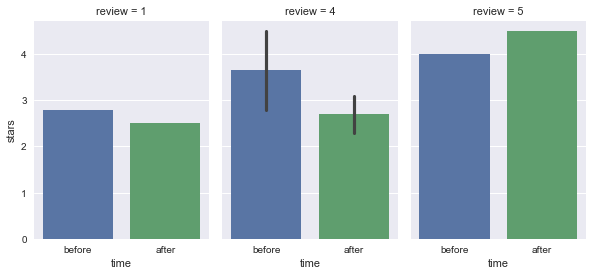

In [116]:
sns.factorplot(x="time", y="stars", col="review",data=trend, kind="bar", size=4, aspect=.7)
plt.show()

We observe that when the influencer review is 1, the average review for the business drops, whereas when its 5, the average review rises. The trend is a mixed bag when it comes to reviews that  are between 1 and 5.